
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet A2021 : Prédire les maladies cardiaques

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/3a185493d8bb48d8961ad50e465bed4f

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Il faudra que vous trouviez un moyen de traiter les données manquantes. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est appropriée.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [7]:
using CSV, DataFrames, Gadfly, GLM, Statistics
include("Math.jl")

"\nLibrairie contenant des fonctions utiles qui sont utilisées dans le calepin principal\n\n"

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [9]:
data = CSV.read("train.csv", DataFrame)
first(data,5)

5×13 DataFrame
 Row │ ID     Age    Sex     ChestPainType  RestingBP  Cholesterol  FastingBS  ⋯
     │ Int64  Int64  String  String         Int64      Int64?       Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     69  M       ASY                  140          110          1  ⋯
   2 │     2     60  M       ASY                  140          293          0
   3 │     3     52  M       ASY                  165      missing          1
   4 │     4     46  M       NAP                  120          230          0
   5 │     5     61  M       NAP                  120      missing          0  ⋯
                                                               6 columns omitted

#### 1.1 Informations sur les données

**Age** : âge du patient (années) </br>

**Sex** : le sexe du patient (M pour homme et F pour femme) </br>

**ChestPainType** : TA: Angine de poitrine typique, ATA: Angine de poitrine atypique, NAP: Douleur autre que l'angine, ASY: Asymptomatique]

Définitions:

Asymptomatique: Aucune douleur

ANGINE: L’angine survient dans des situations où le cœur doit fournir un effort supplémentaire, mais ne parvient pas à recevoir suffisamment d’oxygène en raison du rétrécissement d’une artère coronaire par l’artériosclérose.

TA: Angine typique qui survient lors des efforts connus et reproductibles

ATA: Lorsque l'angine de poitrine atypique alors elle peut de durée prolongée et peut survenir au repos. Habituellement, **une angine instable ou atypique peut être annonciatrice d'un infractus du myocarde (crise cardiaque).**

NAP: Douleur autre que l'angine

Source: https://www.icm-mhi.org/fr/soins-et-services/maladies-cardiovasculaires/angine-de-poitrine

ASY: aucune douleur de chest

**RestingBP** : tension artérielle au repos (en mm Hg)

On a ici les tensions systoliques qui est la force exerc/e lorsque le coeur se contracte et expluse le sang.

Risque faible: 120

Risque moyen: 121-134

Risque élevé: 135+

Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/hypertension-arterielle

**Cholesterol** : taux de cholesterol (en mm/dl)


Le cholestérol est un lipide qui est produit naturellement par le corps, mais dont la quantité peut augmenter en fonction de notre régime alimentaire.


Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/taux-eleve-de-cholesterol

**FastingBS** : glycémie à jeun (1 si FastingBS > 120 mg/dl, 0 sinon)

Hyperglycémie modérée ou diabète.

Source: https://sante.journaldesfemmes.fr/fiches-anatomie-et-examens/2423998-glycemie-a-jeun-taux-normal-definition-elevee-basse-comment-baisser/

**RestingECG** : électrocardiogramme au repos (Normal : normal ; ST : anomalie ST-T détectée ; LVH : hypertrophie du ventricule gauche)


LVH: 

Hypertrophie: Accroissement de la taille du coeur avec les parois du coeur qui s'épaississent. Peut se produire lorsque le coeur subit une charge de travail élevée pendant de longues périodes de temps.
    
Ventricule gauche: épaissement du muscle de la cavité inférieure gauche du coeur

Source: https://www.coeuretavc.ca/maladies-du-coeur/problemes-de-sante/hypertrophie-du-coeur

**MaxHR** : rythme cardiaque maximum (battements par minutes)

**ExerciseAngina** : angine causée par l'exercice (Y: oui ; N: non)

**Oldpeak** : mesure sur l'électrocardiogramme (https://en.wikipedia.org/wiki/ST_depression)

**ST_Slope** : la pente sur l'électrocardiogramme (Up: croissante ; Flat : constante ; Down : décroissante)

Up: Peut etre mauvais

Flat: Bon

Down: Peut etre mauvais

## 2. Analyse exploratoire sommaire

#### 2.1 Diagrammes à moustache en fonction du diagnostic et du sexe

Nous allons faire les boxplots pour toutes les variables quantitatives. Ensuite, nous allons les séparer en catégorie homme/femme pour voir s'il y a une distribution différente, car nos recherches préalables nous montraient que les hommes et les femmes pouvaient avoir une pression normale différente par exemple

#### 2.1.1 RestingBP

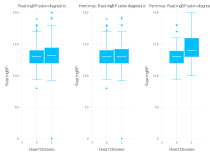

In [23]:
set_default_plot_size(21cm, 16cm)

f1 = plot(data, x=:HeartDisease, y=:RestingBP, Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75), Guide.title("RestingBP selon diagnostic"))
hommes, femmes = groupby(data, :Sex)
f2 = plot(hommes, x=:HeartDisease, y=:RestingBP, Guide.title("Hommes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:RestingBP, Guide.title("Femmes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.3 Cholestérol

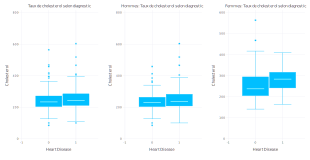

In [22]:
set_default_plot_size(31cm, 16cm)
data_no_missing = dropmissing(data)
f1 = plot(data_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
hommes_no_missing = dropmissing(hommes)
femmes_no_missing = dropmissing(femmes)
f2 = plot(hommes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Hommes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Femmes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.4 MaxHR

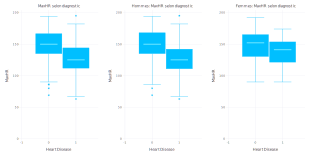

In [19]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Hommes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Femmes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

#### 2.1.5 Age

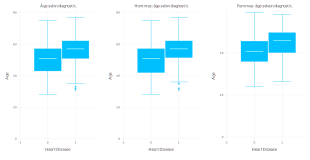

In [25]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Hommes: âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Femmes: âge seleon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])


#### 2.1.6 Oldpeak

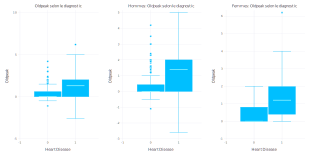

In [29]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Hommes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Femmes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])

#### 2.2 Diagrammes en violon des caractéristiques en fonction du diagnostic

Dans cette section, des **violin plot** sont présentés pour chacune des caractéristique et sont divisés selon le diagnostic du patient. Ces diagrammes permettent de visualiser la densité de probabilité approximative de la caractéristique. Pour cette section d'exploration, seulement les caractéristiques avec des données numériques ont été choisies.
 
#### Observations clés

**Age**:

    - Les personnes en bas de 50 ans semblent avoir une plus petite probabilité d'avoir une maladie cardiaque
    - Le mode des personnes diagnostiquées avec une maladie cardiaque semblent être autour de 55 ans
    - Pouvoir prédictif semble moyen

**RestingBP**:

    - Aucune diffirénce substantielle entre les personnes malades ou non selon cette caractéristique
    - Pouvoir prédictif semble faible
    
**Cholesterol**:

    - Distribution du choléstérol pour les personnes qui ne sont pas malades semblent être une normale centrée en 200
    - Distribution du choléstérol pour les personnes qui malades a deux sommets visibles en 200 et 250
    - Il semble être plus probable d'avoir un cholestérol élevé (250 et plus) si la personne est malade
    - Pouvoir prédictif semble moyen
    
**MaxHR**:

    - Les distributions semlbent être des inverses
    - Les modes pour les personnes malades et non malades sont très différents: 125 vs 160
    - Semble être probable qu'une personne ait un bas rythme cardiaque maximum si elle est malade
    - Pouvoir prédictif semble fort

**Oldpeak**:

    - On voit que la variance de la mesure sur l'électrocardiogramme est très faible pour les personnes non malades
    - Les valeurs sont centrées autours de 0 (une pente nulle du segment ST) pour les personnes non malades
    - Les malades, ont des valeurs souvent supérieures à 0 et le mode est autour de 1.25
    - Possiblité de discrimer les gens non à risque avec une mesure nulle, bien qu'il y ait des execeptions
    - Pouvoir prédictif semble fort


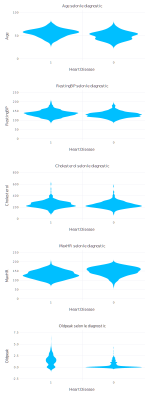

In [32]:
plots = Plot[]

# Enelver les lignes avec des données missing
full_rows_data = dropmissing(data)

# Faire le diagramme seulement pour les caractéristiques numériques
for caracteristic_name in propertynames(full_rows_data[!, [:Age, :RestingBP, :Cholesterol, :MaxHR, :Oldpeak]])
    push!(
        plots,
        plot(
            full_rows_data, 
            x=:HeartDisease,
            y=caracteristic_name,
            Geom.violin,
            Guide.title("$caracteristic_name selon le diagnostic")
        )
    )
end

Gadfly.set_default_plot_size(15cm, 40cm)
Gadfly.
vstack(plots...)

#### 2.3 Histogrammes des caractéristiques en fonction du diagnostic

Pour savoir si certains paramètres suivent des distributions différentes en fonction de la variable d'intérêt (HeartDisease), nous avons généré des histogrammes pour chaque variable dans le cas des patients malades et des patients sains. Cela peut être utile pour déterminer si un mélange de loi peut être utilisé pour certaines variables ou pas.

In [34]:
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

graphs = Plot[]

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.histogram(bincount=20)))
end

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.density()))
end

Gadfly.set_default_plot_size(40cm, 100cm)
Gadfly.gridstack(reshape(graphs, 11, 2))

LoadError: UndefVarError: filled_data not defined

## 3. Ajustement d'un modèle de régression logistique

Ici, je n'utilise que la rythme cardiaque maximum comme variable explicative.

In [ ]:
M = glm(@formula(HeartDisease ~ MaxHR), data, Bernoulli(), LogitLink())

## 4. Prédiction des surverses pour les jours de l'ensemble de test

On utilise le modèle simple de la section précédente pour estimer la probabilité que le patient souffre d'une maladie cardiovasculaire.

#### 4.1 Chargement des données de l'ensemble de test

In [6]:
test = CSV.read("test.csv", DataFrame);

#### 4.2 Prédiction pour chacun des patients de l'ensemble de test

On prédit que le patient souffre d'une maladie cardiovasculaire si la probabilité est supérieure à 50%.

In [7]:
θ̂ = predict(M, test)

ŷ = Int64[]

for θ̂ᵢ in θ̂
    if θ̂ᵢ >= .5
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end


#### 3.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (ID) et d'une colonne des diagnostics prédits.

In [8]:
prediction = DataFrame(ID = test.ID, Prediction = ŷ)

CSV.write("benchmark_predictions.csv", prediction)

"benchmark_predictions.csv"